# Project 2: Train-Test Split Experimentation
## Objective: Investigate how different data splitting strategies affect model performance.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

# Set plot style
sns.set(style="whitegrid")

## 1. Basic Split Analysis
Implement train-test splits with different ratios (60/40, 70/30, 80/20, 90/10) and analyze the bias-variance tradeoff.

In [3]:
# Generate a synthetic dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=42)

split_ratios = [0.6, 0.7, 0.8, 0.9]
train_accuracies = []
test_accuracies = []

for ratio in split_ratios:
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=ratio, random_state=42)
    
    # Train model
    model = LogisticRegression()
    model.fit(X_train, y_train)
    
    # Evaluate
    train_acc = accuracy_score(y_train, model.predict(X_train))
    test_acc = accuracy_score(y_test, model.predict(X_test))
    
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    print(f"Split {int(ratio*100)}/{int((1-ratio)*100)} - Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

Split 60/40 - Train Acc: 0.8233, Test Acc: 0.8075
Split 70/30 - Train Acc: 0.8143, Test Acc: 0.8200
Split 80/19 - Train Acc: 0.8150, Test Acc: 0.8250
Split 90/9 - Train Acc: 0.8189, Test Acc: 0.8300


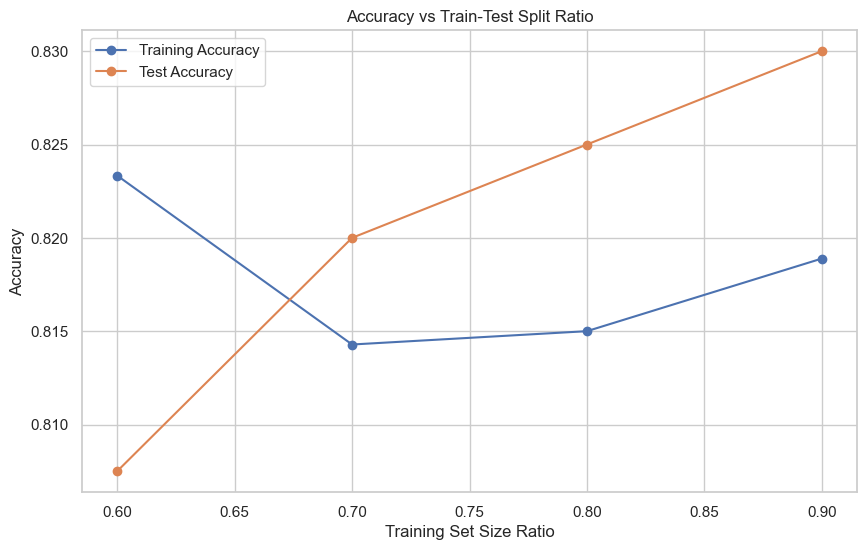

In [4]:
# Plotting results
plt.figure(figsize=(10, 6))
plt.plot(split_ratios, train_accuracies, marker='o', label='Training Accuracy')
plt.plot(split_ratios, test_accuracies, marker='o', label='Test Accuracy')
plt.title('Accuracy vs Train-Test Split Ratio')
plt.xlabel('Training Set Size Ratio')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Analysis of Bias-Variance Tradeoff

**Observations:**
- **Smaller Training Set (60/40):** The model might underfit if the data is complex, but the test set is larger, giving a more reliable estimate of performance (lower variance in performance estimation).
- **Larger Training Set (90/10):** The model has more data to learn from (potentially lower bias), but the test set is small, which can lead to high variance in the performance estimate (the test score might fluctuate a lot depending on which specific points end up in the test set).

## 2. Stratified Splitting
For imbalanced classification problems, compare regular vs stratified splitting.

In [5]:
# Generate imbalanced dataset
X_imb, y_imb = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, weights=[0.9, 0.1], random_state=42)

# Regular Split
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_imb, y_imb, test_size=0.3, random_state=42)

# Stratified Split
X_train_strat, X_test_strat, y_train_strat, y_test_strat = train_test_split(X_imb, y_imb, test_size=0.3, stratify=y_imb, random_state=42)

# Check distributions
print("Regular Split Class Distribution (Train):")
print(pd.Series(y_train_reg).value_counts(normalize=True))
print("\nStratified Split Class Distribution (Train):")
print(pd.Series(y_train_strat).value_counts(normalize=True))

Regular Split Class Distribution (Train):
0    0.891429
1    0.108571
Name: proportion, dtype: float64

Stratified Split Class Distribution (Train):
0    0.898571
1    0.101429
Name: proportion, dtype: float64


In [6]:
# Train and Evaluate
model_reg = LogisticRegression()
model_reg.fit(X_train_reg, y_train_reg)
y_pred_reg = model_reg.predict(X_test_reg)

model_strat = LogisticRegression()
model_strat.fit(X_train_strat, y_train_strat)
y_pred_strat = model_strat.predict(X_test_strat)

print(f"Regular Split F1 Score: {f1_score(y_test_reg, y_pred_reg):.4f}")
print(f"Stratified Split F1 Score: {f1_score(y_test_strat, y_pred_strat):.4f}")

Regular Split F1 Score: 0.4651
Stratified Split F1 Score: 0.3913


### Analysis of Stratified Splitting
Stratified splitting ensures that the class distribution in the training and test sets matches the original dataset. This is crucial for imbalanced datasets because a random split might end up with very few (or no) minority class examples in the test set, leading to unreliable evaluation.

## 3. Time-Series Splitting
Implement proper temporal splitting and compare with random splitting.

In [7]:
# Generate Time-Series Data
np.random.seed(42)
dates = pd.date_range(start='2023-01-01', periods=100, freq='D')
values = np.linspace(0, 10, 100) + np.random.randn(100)
df_ts = pd.DataFrame({'Date': dates, 'Value': values})
df_ts.set_index('Date', inplace=True)

# Create features (lagged values)
df_ts['Lag1'] = df_ts['Value'].shift(1)
df_ts.dropna(inplace=True)

X_ts = df_ts[['Lag1']]
y_ts = (df_ts['Value'] > df_ts['Lag1']).astype(int) # Simple classification task: Up or Down

# TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

print("TimeSeriesSplit indices:")
for i, (train_index, test_index) in enumerate(tscv.split(X_ts)):
    print(f"Fold {i}: Train indices: {train_index[:5]}...{train_index[-5:]}, Test indices: {test_index}")

TimeSeriesSplit indices:
Fold 0: Train indices: [0 1 2 3 4]...[14 15 16 17 18], Test indices: [19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34]
Fold 1: Train indices: [0 1 2 3 4]...[30 31 32 33 34], Test indices: [35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50]
Fold 2: Train indices: [0 1 2 3 4]...[46 47 48 49 50], Test indices: [51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66]
Fold 3: Train indices: [0 1 2 3 4]...[62 63 64 65 66], Test indices: [67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82]
Fold 4: Train indices: [0 1 2 3 4]...[78 79 80 81 82], Test indices: [83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98]


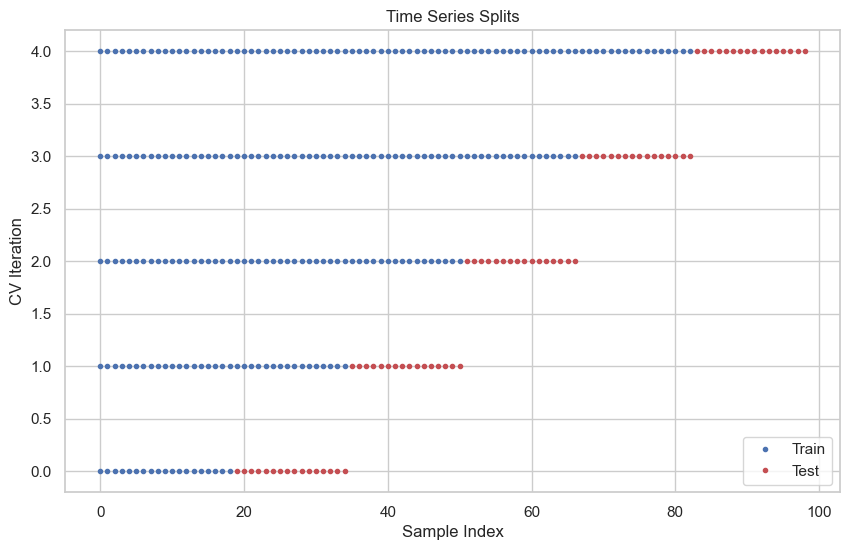

In [8]:
# Visualize Splits
plt.figure(figsize=(10, 6))
for i, (train_index, test_index) in enumerate(tscv.split(X_ts)):
    plt.plot(train_index, [i] * len(train_index), 'b.', label='Train' if i == 0 else "")
    plt.plot(test_index, [i] * len(test_index), 'r.', label='Test' if i == 0 else "")

plt.title('Time Series Splits')
plt.xlabel('Sample Index')
plt.ylabel('CV Iteration')
plt.legend()
plt.show()

### Analysis of Time-Series Splitting
- **Random Splitting in Time-Series:** Random splitting would mix future and past data, leading to data leakage. The model would learn from the future to predict the past, which is unrealistic for forecasting.
- **Walk-Forward Validation:** As shown in the plot, the training set grows over time, and the test set is always "future" relative to the training set. This mimics real-world deployment.